In [1]:
import dask
import dask.threaded
import dask.multiprocessing
from dask.distributed import Client

c = Client()


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:74: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


In [2]:
c

Client Scheduler: tcp://127.0.0.1:35777 Dashboard: http://127.0.0.1:40370/status,Cluster Workers: 8 Cores: 48 Memory: 134.91 GB


In [3]:
import xarray as xr 
import dask 
import numpy as np 
import os 
import time 
import glob
from datetime import date
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib as mat

today=date.today()


#https://pmall.univ-grenoble-alpes.fr/docs/auto_examples_code/windrose/windrose-exemple.html

In [4]:
Date_sept=['20120901','20120902','20120903','20120904','20120905','20120906','20120907','20120908','20120909','20120910','20120911','20120912','20120913','20120914','20120915','20120916','20120917','20120918','20120919','20120920','20120921','20120922','20120923','20120924','20120925','20120926','20120927','20120928','20120929','20120930']
Date_march=['20130301','20130302','20130303','20130304','20130305','20130306','20130307','20130308','20130309','20130310','20130311','20130312','20130313','20130314','20130315','20130316','20130317','20130318','20130319','20130320','20130321','20130322','20130323','20130324','20130325','20130326','20130327','20130328','20130329','20130330']
Date_month={'march':Date_march,'sept':Date_sept}

In [5]:
def get_phi_angle(box,month):
    print('get phi and turner angle for box '+str(box)+' and month '+str(month))
    Date=Date_month[month]
    datasets_phi = []
    datasets_tu = []
    for date in Date:
        zphi_file = '/scratch/cnt0024/hmg2840/albert7a/NATL60/NATL60-CJM165-S/1d/turner-angle/NATL60-CJM165_phi_norm_'+str(date)+'.1d_'+str(box)+'.nc'
        ztu_file='/scratch/cnt0024/hmg2840/albert7a/NATL60/NATL60-CJM165-S/1d/turner-angle/NATL60-CJM165_Tu_norm_'+str(date)+'.1d_'+str(box)+'.nc'
        zdsphi=xr.open_dataset(zphi_file)
        zdstu=xr.open_dataset(ztu_file)
        datasets_phi.append(zdsphi)
        datasets_tu.append(zdstu)
    all_phi=xr.concat(datasets_phi,dim='z')
    all_tu=xr.concat(datasets_tu,dim='z')
    phi=all_phi['phi']
    Tu=all_tu['Tu']
    return phi,Tu
   
    
    

In [6]:
phi_sept_AC,Tu_sept_AC=get_phi_angle('AC','sept')
phi_march_AC,Tu_march_AC=get_phi_angle('AC','march')
#phi_sept_GS,Tu_sept_GS=get_phi_angle('GS','sept')
#phi_march_GS,Tu_march_GS=get_phi_angle('GS','march')
#phi_sept_NE,Tu_sept_NE=get_phi_angle('NE','sept')
#phi_march_NE,Tu_march_NE=get_phi_angle('NE','march')


get phi and turner angle for box AC and month sept
get phi and turner angle for box AC and month march


In [7]:
def sectors_for_windrose(phi,Tu,nb_angle,nb_phi):
    
    C = np.zeros([nb_angle,nb_phi])
    
    r = np.linspace(0,2,nb_angle)
    theta = np.linspace(-1*np.pi,np.pi,nb_phi)

  
    Theta, R = np.meshgrid(theta, r)
    
    def density(tumin,tumax,phimin,phimax):
        return len(np.where( (tumin<Tu.values) * (Tu.values<tumax) * (phimin<phi.values) * (phi.values<phimax)  )[0])/ len(phi)
   
    for j in np.arange(nb_phi-1):
        for i in np.arange(nb_angle-1):
            
            phimin=theta[j]
            phimax=theta[j+1]
            tumin=r[i]
            tumax=r[i+1]
            C[i,j]=density(tumin,tumax,phimin,phimax)
        
    return Theta, R, C
        


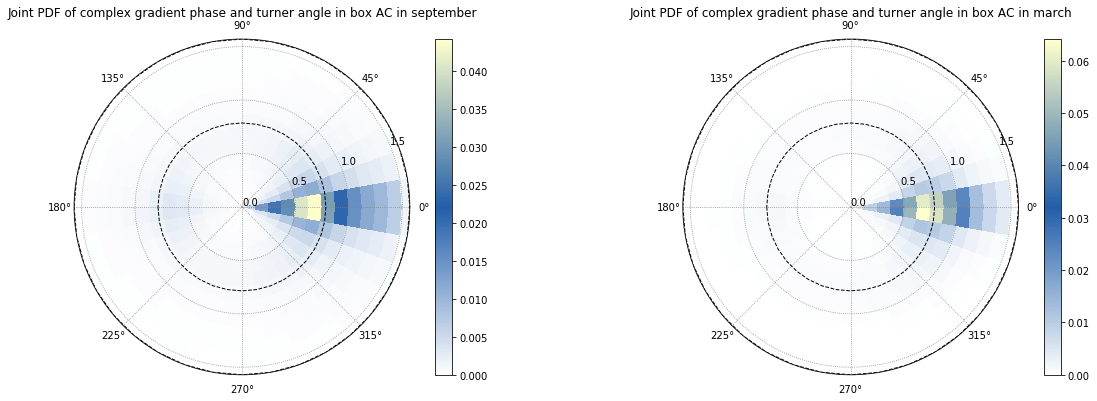

In [9]:
Theta_sept_AC, R_sept_AC, C_sept_AC= sectors_for_windrose(phi_sept_AC,Tu_sept_AC,17,37)
Theta_march_AC, R_march_AC, C_march_AC= sectors_for_windrose(phi_march_AC,Tu_march_AC,17,37)
#Theta_sept_GS, R_sept_GS, C_sept_GS= sectors_for_windrose(magR_sept_GS,Tu_sept_GS,17,20)
#Theta_march_GS, R_march_GS, C_march_GS= sectors_for_windrose(magR_march_GS,Tu_march_GS,17,20)
#Theta_sept_NE, R_sept_NE, C_sept_NE= sectors_for_windrose(magR_sept_NE,Tu_sept_NE,17,20)
#Theta_march_NE, R_march_NE, C_march_NE= sectors_for_windrose(magR_march_NE,Tu_march_NE,17,20)

# white -> blue -> yellow
colors = ['#FFFFFF', '#225ea8', '#ffffcc']# create color maps and normalization
density_cmap = mat.colors.LinearSegmentedColormap.from_list('my_cmap', colors)
density_norm = mat.colors.PowerNorm(0.5, vmin=0, vmax=100)

thet=np.linspace(-1*np.pi,np.pi,37)

fig = plt.figure(figsize=(20, 21))

ax = fig.add_subplot(321, projection='polar')
pcolor=ax.pcolormesh(Theta_sept_AC, R_sept_AC, C_sept_AC,cmap=density_cmap)
plt.ylim(0,np.pi/2)
plt.yticks([0,0.5,1,1.5])
ax.tick_params(axis='y',colors="k")
ax.grid(True,linestyle='dotted', color='grey')
ax.plot(thet,[np.pi/4 for t in thet],color='k',linewidth=1,linestyle='dashed')
ax.plot(thet,[np.pi/2 for t in thet],color='k',linewidth=1,linestyle='dashed')
plt.colorbar(pcolor)
plt.title('Joint PDF of complex gradient phase and turner angle in box AC in september')

ax = fig.add_subplot(322, projection='polar')
pcolor=ax.pcolormesh(Theta_march_AC, R_march_AC, C_march_AC,cmap=density_cmap)
plt.ylim(0,np.pi/2)
plt.yticks([0,0.5,1,1.5])
ax.tick_params(axis='y',colors="k")
ax.grid(True,linestyle='dotted', color='grey')
ax.plot(thet,[np.pi/4 for t in thet],color='k',linewidth=1,linestyle='dashed')
ax.plot(thet,[np.pi/2 for t in thet],color='k',linewidth=1,linestyle='dashed')
plt.colorbar(pcolor)
plt.title('Joint PDF of complex gradient phase and turner angle in box AC in march')

plt.savefig('polar_plot_phi_tu_AC.png')

In [ ]:
ax = fig.add_subplot(323, projection='polar')
pcolor=ax.pcolormesh(Theta_sept_GS, R_sept_GS, C_sept_GS,cmap=density_cmap)
plt.ylim(0,np.pi/2)
plt.yticks([0,0.5,1,1.5])
ax.tick_params(axis='y',colors="k")
ax.grid(True,linestyle='dotted', color='grey')
ax.plot(thet,[np.pi/4 for t in thet],color='k',linewidth=1,linestyle='dashed')
ax.plot(thet,[np.pi/2 for t in thet],color='k',linewidth=1,linestyle='dashed')
plt.colorbar(pcolor)
plt.title('Joint PDF of complex gradient phase and turner angle in box GS in september')

ax = fig.add_subplot(324, projection='polar')
pcolor=ax.pcolormesh(Theta_march_GS, R_march_GS, C_march_GS,cmap=density_cmap)
plt.ylim(0,np.pi/2)
plt.yticks([0,0.5,1,1.5])
ax.tick_params(axis='y',colors="k")
ax.grid(True,linestyle='dotted', color='grey')
ax.plot(thet,[np.pi/4 for t in thet],color='k',linewidth=1,linestyle='dashed')
ax.plot(thet,[np.pi/2 for t in thet],color='k',linewidth=1,linestyle='dashed')
plt.colorbar(pcolor)
plt.title('Joint PDF of complex gradient phase and turner angle in box GS in march')

ax = fig.add_subplot(325, projection='polar')
pcolor=ax.pcolormesh(Theta_sept_NE, R_sept_NE, C_sept_NE,cmap=density_cmap)
plt.ylim(0,np.pi/2)
plt.yticks([0,0.5,1,1.5])
ax.tick_params(axis='y',colors="k")
ax.grid(True,linestyle='dotted', color='grey')
ax.plot(thet,[np.pi/4 for t in thet],color='k',linewidth=1,linestyle='dashed')
ax.plot(thet,[np.pi/2 for t in thet],color='k',linewidth=1,linestyle='dashed')
plt.colorbar(pcolor)
plt.title('Joint PDF of complex gradient phase and turner angle in box NE in september')

ax = fig.add_subplot(326, projection='polar')
pcolor=ax.pcolormesh(Theta_march_NE, R_march_NE, C_march_NE,cmap=density_cmap)
plt.ylim(0,np.pi/2)
plt.yticks([0,0.5,1,1.5])
ax.tick_params(axis='y',colors="k")
ax.grid(True,linestyle='dotted', color='grey')
ax.plot(thet,[np.pi/4 for t in thet],color='k',linewidth=1,linestyle='dashed')
ax.plot(thet,[np.pi/2 for t in thet],color='k',linewidth=1,linestyle='dashed')
plt.colorbar(pcolor)
plt.title('Joint PDF of complex gradient phase and turner angle in box NE in march')
